# Discovery into StackExchange
We want to analyze the data from StackExchange. We collected the data from StackExchange Data Dump website and tried to answer two questions. First, we wanted to find the trending topic over time. Second we wanted to predict the socre of a post given its raw features.


We will cover the following topics in this report.
- [Background and Introduction](#Background-and-Introduction)
- [Load required libraries](#Load-required-libraries)
- [Load the data](#Load-the-data)
- [Visualize topic trend and predict future trend](#Visualize-topic-trend-and-predict-future-trend)
- [Predict the Score of a Post](#Predict-the-Score-of-a-Post)
- [Conclusion and Future Work](#Conclusion-and-Future-work)

# Background and Introduction
[StackExchange](https://stackexchange.com/) is a network of Q&A websites on topics in varied fields.
![image.png](./image.jpg)
As shown in the picture, there are varieties of questions with different topics that users can view and answer.  
In our final project, we want to explore the topic trend and predict kthe future trend of a specific topic. We also build a model to predict what kind of questions are more likely to be answered and what are not.

# Load required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline
import nltk
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the data 
The data is available at  
<center>https://archive.org/details/stackexchange</center>
We first download the dataset and saved in different csv files.


In [4]:
tag_df = pd.read_csv('tags.csv')
badge_df = pd.read_csv('badges.csv')
comment_df = pd.read_csv('comments.csv')
posthistory_df = pd.read_csv('posthistories.csv')
postlink_df = pd.read_csv('postlinks.csv')
post_df = pd.read_csv('posts.csv')
user_df = pd.read_csv('users.csv')
vote_df = pd.read_csv('votes.csv')

# Visualize topic trend and predict future trend
## Preprocessing
Drop the pose without any tags.

In [5]:
post_df_with_tag = post_df.dropna(subset=['Tags'])

Separate the data by tags.

In [10]:
a = post_df_with_tag["Tags"]
dict = {}
k = 0
for i in a:
    ii = i.split('>')
    for j in ii:
        if j == '':
            continue
        j = j[1:]
        if j not in dict.keys():
            dict[j] = []
        dict[j].append(k)

    k += 1


Select topic with enough data, since most topics only have few posts.

In [24]:
newdict = {}
for k, v in dict.items():
    if len(v) > 800:
        newdict[k] = v
newdict.keys()

dict_keys(['machine-learning', 'python', 'classification', 'neural-network', 'deep-learning'])

## Visualize the topic trend
Get all timestamps for all posts.

In [16]:
all_times = post_df_with_tag['LastActivityDate']
all_times = sorted(all_times)
all_times = pd.to_datetime(all_times)
data = np.ones(len(all_times))
all_times = pd.DataFrame({'date':all_times, 'data':data}).set_index('date').resample('M').sum()
all_times = all_times.divide(all_times['data'].sum(), axis=1)

Get timestamps for specific topics and plot them in a single figure.

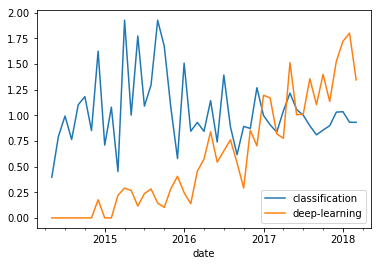

In [22]:
times_dict = {}
#We only concern about classification and deep-learning
banned = ['machine-learning', 'python', 'neural-network']
a = []
for k, s in newdict.items():
    if k in banned:
        continue
    times= []
    for i in s:
        times.append(post_df_with_tag.iloc[i]['LastActivityDate'])
    times = sorted(times)
    times = pd.to_datetime(times)
    data = np.ones(len(times))

    times = pd.DataFrame({'date': times, k: data})
    times = times.set_index('date')
    times = times.resample('M').sum()
    times = times.divide(times[k].sum(), axis=1)
    times_dict[k] = times
    a = times
    
prev = all_times
for k, v in times_dict.items():
    prev = prev.merge(v, how='outer', left_index=True, right_index=True)
prev = prev.fillna(0)
prev = prev.divide(prev['data'], axis=0)
prev = prev.drop('data', axis=1)
prev.plot()

As shown in the figure, classification is more popular in 2015 and 2016 while deep-learning becomes more and more popular recently.
## Predict the future trend of a specific topic
As time series data, we want to predict the future trend. Facebook provide a simple library called Prophet to process time series data. We first group our timestamp by week and try to predict the future trend of deep-learning.

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


           ds        yhat  yhat_lower  yhat_upper
87 2019-02-24  107.052077   89.752112  126.086088
88 2019-03-03  102.752774   85.208142  121.722691
89 2019-03-10   94.547662   72.544854  111.668680
90 2019-03-17   86.318115   65.105050  105.688182
91 2019-03-24   82.523892   62.821638  101.219894


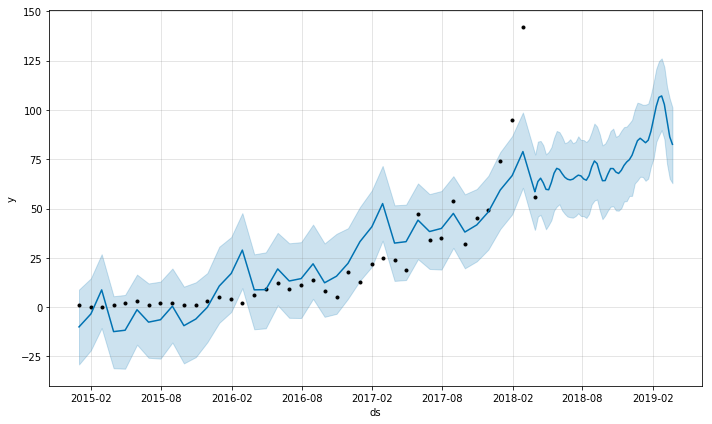

In [21]:
from fbprophet import Prophet
# Create the model
m = Prophet(weekly_seasonality=False, daily_seasonality=False)

# Process the data as desired for the library
df = times_dict['deep-learning'].rename({'deep-learning':'y', 'date': 'ds'}, axis='columns')
df['ds'] = df.index

# Fit the model
m.fit(df)

# Create the future and predict
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

# Visualize the results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
m.plot(forecast);

As shown in the graph, deep-learning will still be more and more popular in the next year.

# Predict the Score of a Post

Our second task is to predict the Score of a post given its features.

## Read dataframe from file

A post consists of the following components.

In [12]:
post_df.head()

,Unnamed: 0,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,0,5,1,NaN,NaN,2014-05-13T23:58:30.457,8,412.0,<p>I've always been interested in machine lear...,5.0,...,NaN,NaN,2014-05-14T00:36:31.077,NaN,2014-05-14T14:40:25.950,How can I do simple machine learning without h...,<machine-learning>,1.0,1,1.0
1,1,7,1,NaN,10.0,2014-05-14T00:11:06.457,4,363.0,"<p>As a researcher and instructor, I'm looking...",36.0,...,NaN,2014-05-16T13:45:00.237,2014-05-16T13:45:00.237,NaN,2014-05-14T08:40:54.950,What open-source books (or other materials) pr...,<education><open-source>,3.0,4,1.0
2,2,9,2,5.0,NaN,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,...,NaN,NaN,2014-05-14T00:36:31.077,NaN,NaN,NaN,NaN,NaN,0,NaN
3,3,10,2,7.0,NaN,2014-05-14T00:53:43.273,12,NaN,"<p>One book that's freely available is ""The El...",22.0,...,NaN,NaN,2014-05-14T00:53:43.273,NaN,NaN,NaN,NaN,NaN,1,NaN
4,4,14,1,NaN,29.0,2014-05-14T01:25:59.677,19,999.0,<p>I am sure data science as will be discussed...,66.0,...,NaN,2014-06-17T16:17:20.473,2014-06-20T17:36:05.023,NaN,NaN,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4.0,1,4.0


PostTypeId has 2 values, 1 and 2. 1 refers to questions, 2 refers to answers.

First we want to do some data cleaning job, we removed the Unnamed column which is just for index, selected all the question posts and save saved it to question_post dataframe and then reset the index.

In [13]:
post_df = post_df.drop(['Unnamed: 0'], axis=1)
question_post = post_df[post_df['PostTypeId'] == 1]
question_post = question_post.reset_index()
question_post.head()

,index,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,0,5,1,NaN,NaN,2014-05-13T23:58:30.457,8,412.0,<p>I've always been interested in machine lear...,5.0,...,NaN,NaN,2014-05-14T00:36:31.077,NaN,2014-05-14T14:40:25.950,How can I do simple machine learning without h...,<machine-learning>,1.0,1,1.0
1,1,7,1,NaN,10.0,2014-05-14T00:11:06.457,4,363.0,"<p>As a researcher and instructor, I'm looking...",36.0,...,NaN,2014-05-16T13:45:00.237,2014-05-16T13:45:00.237,NaN,2014-05-14T08:40:54.950,What open-source books (or other materials) pr...,<education><open-source>,3.0,4,1.0
2,4,14,1,NaN,29.0,2014-05-14T01:25:59.677,19,999.0,<p>I am sure data science as will be discussed...,66.0,...,NaN,2014-06-17T16:17:20.473,2014-06-20T17:36:05.023,NaN,NaN,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4.0,1,4.0
3,5,15,1,NaN,NaN,2014-05-14T01:41:23.110,2,494.0,<p>In which situations would one system be pre...,64.0,...,NaN,NaN,2014-05-14T01:41:23.110,NaN,2014-05-14T07:41:49.437,What are the advantages and disadvantages of S...,<databases>,0.0,1,NaN
4,6,16,1,NaN,46.0,2014-05-14T01:57:56.880,17,302.0,"<p>I use <a href=""http://www.csie.ntu.edu.tw/~...",63.0,...,NaN,2014-05-17T16:24:14.523,2014-05-17T16:24:14.523,NaN,NaN,Use liblinear on big data for semantic analysis,<machine-learning><bigdata><libsvm>,2.0,0,NaN


Next, let's plot the histogram of the Score that we want to predict.

(array([4.280e+02, 7.158e+03, 7.800e+02, 1.260e+02, 5.300e+01, 2.000e+01,
        1.000e+01, 1.600e+01, 6.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([ -6.  ,  -0.76,   4.48,   9.72,  14.96,  20.2 ,  25.44,  30.68,
         35.92,  41.16,  46.4 ,  51.64,  56.88,  62.12,  67.36,  72.6 ,
         77.84,  83.08,  88.32,  93.56,  98.8 , 104.04, 109.28, 114.52,
        119.76, 125.  ]),
 <a list of 25 Patch objects>)

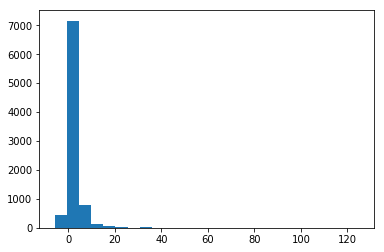

In [14]:
plt.hist(question_post['Score'], bins=25)

We want to use four features to predict the score of a question. The four featuers are TagCount, FavoriteCount,
AnswerCount and ViewCount.
Since TagCount are derived from the number of tags for each sample, we want to do this feature preprocessing first and 
extract the TagCount from the Tag column.

### Preprocessing

In [15]:
question_post['TagCount'] = question_post['Tags'].apply(lambda x: x.count('<'))
question_post['FavoriteCount'] = question_post['FavoriteCount'].replace(np.nan, 0)

Since we are using multiple features, let's scale the features to 0 and 1 using Feature Scaling.
$$X'=\frac{X-X_{min}}{X_{max}-X_{min}}$$

In [16]:
def feature_scaling(df):
    df = (df - np.min(df)) / (np.max(df) - np.min(df))
    return df

features_to_scale = ['TagCount', 'AnswerCount', 'FavoriteCount', 'ViewCount']
for feature in features_to_scale:
    question_post[feature] = feature_scaling(question_post[feature])

In [17]:
X = np.hstack([question_post[['TagCount']].values, question_post[['AnswerCount']].values, 
              question_post[['FavoriteCount']].values, question_post[['ViewCount']].values])
y = question_post['Score']

Now we have our features as variable X and labels as variable y, we want to use GradientBoostingRegressor to predict 
our score value based on the four features.

First we split our dataset into train, validation and test set. We trained our model on the training set, and calculate the MSE on those three sets. We also set a baseline model where we predicted everything as the mean score of the training set and compared these two results.

### Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, clf.predict(X_train))
cv_mse = mean_squared_error(y_cv, clf.predict(X_cv))
test_mse = mean_squared_error(y_test, clf.predict(X_test))
print('training mse:', train_mse)
print('cross validation mse:',cv_mse)
print('test mse:', test_mse)
print('baseline test mse:', np.mean((np.mean(y_train) - y_test)**2))

training mse: 3.3587637843569147
cross validation mse: 4.914884101675999
test mse: 6.83699852921642
baseline test mse: 20.39818692697685


Our test MSE improved a lot compared with the baseline model.

Furthermore, we used 10 fold cross validation to compute the average MSE.

In [19]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
total_kfold_mse = 0
num = 0
for train_index, cv_index in kf.split(X_):
    X_train, X_cv = X_[train_index], X_[cv_index]
    y_train, y_cv = y_.iloc[train_index], y_.iloc[cv_index]
    clf = GradientBoostingRegressor()
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_cv, clf.predict(X_cv))
    total_kfold_mse += mse
    num +=1
print('average kfold mse:', total_kfold_mse / num)

average kfold mse: 5.71563669521835


Next we want to find the relationship between the number of samples we take as training set and the loss of our model.

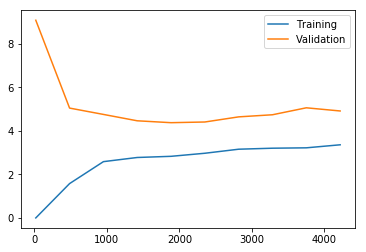

In [20]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
clf.fit(X_train, y_train)

def get_loss_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    training_prediction = clf.predict(X[:n_samples])
    cv_prediction = clf.predict(X_cv)
    train_mse = mean_squared_error(y[:n_samples], training_prediction)
    cv_mse = mean_squared_error(y_cv, cv_prediction)
    return np.array([train_mse, cv_mse])

n_samples = [int(x) for x in np.linspace(20, X_train.shape[0], 10)]
loss = np.array([get_loss_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, loss[:,0], n_samples, loss[:,1])
plt.legend(["Training", "Validation"])

## Polynomial Features

Now let's try to add some polynomial features. Since the question_post dataframe has already been normalized, we want to initialize that again and add polynomial to some of its features.

In [21]:
question_post = post_df[post_df['PostTypeId'] == 1]
question_post = question_post.reset_index()
question_post['TagCount'] = question_post['Tags'].apply(lambda x: x.count('<'))
question_post['FavoriteCount'] = question_post['FavoriteCount'].replace(np.nan, 0)

Let's see the relationship of our four features with Score respectively.

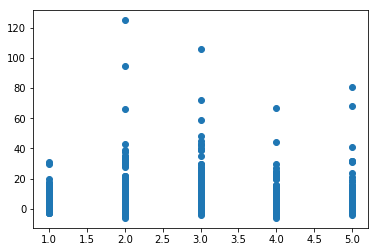

In [22]:
plt.scatter(question_post['TagCount'], question_post['Score'])

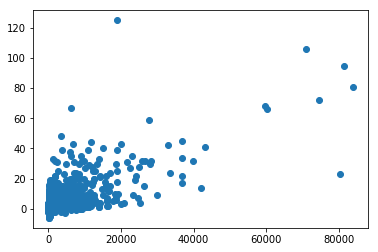

In [23]:
plt.scatter(question_post['ViewCount'], question_post['Score'])

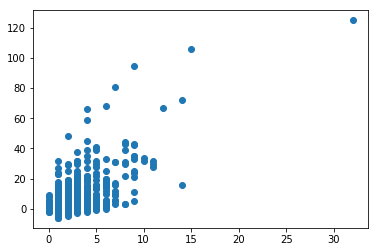

In [24]:
plt.scatter(question_post['AnswerCount'], question_post['Score'])

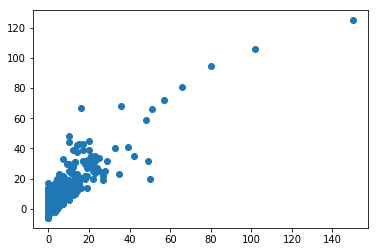

In [25]:
plt.scatter(question_post['FavoriteCount'], question_post['Score'])

It seems that the Score grows with the FavoriteCount and the ViewCount grows. So we will try to do polynomial on those two features.

In [26]:
X = np.hstack([question_post[['TagCount']].values, question_post[['AnswerCount']].values, 
              question_post[['FavoriteCount']].values, question_post[['ViewCount']].values])
y = question_post['Score']

Let's first look at how our model performs without normalizing

In [27]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, clf.predict(X_train))
cv_mse = mean_squared_error(y_cv, clf.predict(X_cv))
test_mse = mean_squared_error(y_test, clf.predict(X_test))
print('training mse:', train_mse)
print('cross validation mse:',cv_mse)
print('test mse:', test_mse)
print('baseline test mse:', np.mean((np.mean(y_train) - y_test)**2))


training mse: 3.3587637843569147
cross validation mse: 4.908544777548613
test mse: 6.815526596597427
baseline test mse: 20.39818692697685


10 fold cross validation

In [28]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
total_kfold_mse = 0
num = 0
for train_index, cv_index in kf.split(X_):
    X_train, X_cv = X_[train_index], X_[cv_index]
    y_train, y_cv = y_.iloc[train_index], y_.iloc[cv_index]
    clf = GradientBoostingRegressor()
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_cv, clf.predict(X_cv))
    total_kfold_mse += mse
    num +=1
print('average kfold mse:', total_kfold_mse / num)

average kfold mse: 5.740408436784021


Now let's look at our model performance when we have different polynomials on ViewCounts and FavoriteCounts. We plotted the figure showing the change of our loss value with the change of the polynomial number.

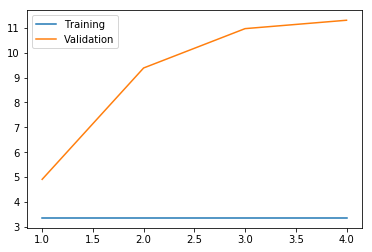

In [29]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
def get_loss_polynomials(clf, X, y, X_cv, y_cv, polynomials):
    favorate = X[:, [2]] ** polynomials
    view = X[:, [3]] ** polynomials
    X = np.hstack([X[:,[0]], X[:, [1]], favorate, view])
    clf.fit(X, y)
    training_prediction = clf.predict(X)
    cv_prediction = clf.predict(X_cv)
    train_mse = mean_squared_error(y, training_prediction)
    cv_mse = mean_squared_error(y_cv, cv_prediction)
    return np.array([train_mse, cv_mse])

polynomials = [1,2,3,4]
loss = np.array([get_loss_polynomials(clf, X_train, y_train, X_cv, y_cv, n) for n in polynomials])
plt.plot(polynomials, loss[:,0], polynomials, loss[:,1])
plt.legend(["Training", "Validation"])

We can draw the conclusion that polynomial 1 is the best polynomial for our model and the loss on cross validation set is about 5. So not adding any polynomial feature produced the best result in this case.

## Predict from titles

Now we want to use our title along with other features we discussed above to predict the score. Since when we want to predict whether it's a good question or not we always look at the title of this question first. In this case we use n-gram and tfidf to extract features from the title.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3), stop_words=stopwords.words('english'))
X_tfidf = tfidf.fit_transform(question_post['Title']).toarray()

In [31]:
X = np.hstack([X_tfidf, question_post[['TagCount']].values, question_post[['AnswerCount']].values, 
              question_post[['FavoriteCount']].values, question_post[['ViewCount']].values])
y = question_post['Score']


In [32]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, clf.predict(X_train))
cv_mse = mean_squared_error(y_cv, clf.predict(X_cv))
test_mse = mean_squared_error(y_test, clf.predict(X_test))
print('training mse:', train_mse)
print('cross validation mse:',cv_mse)
print('test mse:', test_mse)
print('baseline test mse:', np.mean((np.mean(y_train) - y_test)**2))



training mse: 3.0061954893305063
cross validation mse: 4.624655165442201
test mse: 7.621649236886499
baseline test mse: 20.39818692697685


Compared with our original model, the cross validation mse decreased a little bit but the test mse increased a little bit. So we don't think adding title features actually help determine the score of a post better.

In [33]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
total_kfold_mse = 0
num = 0
for train_index, cv_index in kf.split(X_):
    X_train, X_cv = X_[train_index], X_[cv_index]
    y_train, y_cv = y_.iloc[train_index], y_.iloc[cv_index]
    clf = GradientBoostingRegressor()
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_cv, clf.predict(X_cv))
    total_kfold_mse += mse
    num +=1
print('average kfold mse:', total_kfold_mse / num)

average kfold mse: 5.662273978421756


However, the mse is still roughly the same.

## Classification Problem

Now let's try turn that regression problem into a classification problem and see whether can predict a good question question from a bad one. The way we define good questions and bad questions is quite simple. We define the question whose Score is lower than the median score as bad questions, and the one whose score is higher than the median score as the good question.

In [34]:
for feature in features_to_scale:
    question_post[feature] = feature_scaling(question_post[feature])
X = np.hstack([question_post[['TagCount']].values, question_post[['AnswerCount']].values, 
              question_post[['FavoriteCount']].values, question_post[['ViewCount']].values])

In [35]:
X.shape

(8612, 4)

We take top and bottom 10 percent samples in Score to do this prediction task, which may increase the accuracy of our model.

In [36]:
y = question_post['Score'] > np.median(question_post['Score'])
idx = ((question_post['Score'] >= np.percentile(question_post['Score'], 90)) |
       (question_post['Score'] <= np.percentile(question_post['Score'], 10))).values

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
X_, X_test, y_, y_test = train_test_split(X[idx,:], y[idx], test_size = 0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_cv, y_cv))


0.9276169265033407
0.9272727272727272


In [38]:
print('accuracy=', clf.score(X_test, y_test))

accuracy= 0.8955495004541326


The accuracy is quite good! Now let's plot the error-sample figure.

In [39]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([clf.score(X[:n_samples], y[:n_samples]), clf.score(X_cv, y_cv)])

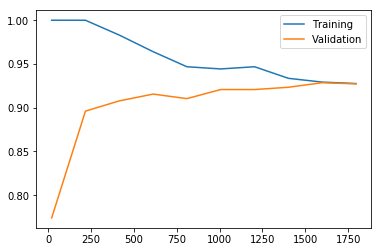

In [40]:
n_samples = [int(x) for x in np.linspace(20, X_train.shape[0], 10)]
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])

Since the test set data is quite skewed (3/4 of the samples are negative), let's look at our precision recall score.

In [41]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_test, clf.predict(X_test), average='binary')
recall = recall_score(y_test, clf.predict(X_test), average='binary')
print(precision)
print(recall)

0.8171641791044776
0.7684210526315789


The precision score is quite high which means we predicted most of the right cases in our postive prediction. However, we didn't do well in recall score which means we weren't able to predict more positive cases.

Finally let's plot the precision-recall curve.

(0.0, 1.0)

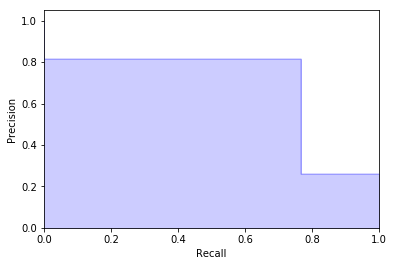

In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])


# Conclusion and Future work

In conclusion, we explored the data in the datascience topic at StackExchange. We found the trending topic over time and predicted the score of a topic given the raw features we get from the StackExchange data dump website. 

We think there are still a lot of work that we can do to improve our prediction. First, we can try to use user reputation as a feature. In order to do this, we need to join two tables together. Besides that, we can try to use a one hot encoding method to extract the tag feature and use that to predict our socre as well.

Other than that, we can predict more things. For example, the viewcount of a post that defines the popularity of the question. The answercount of a question that indicates whether the question are tended to be answered or ignored and so on.